# Machine Learning: Predict Job Quality

**Tian Lou** \
Ohio Education Research Center \
The Ohio State University

**Xiangyu Ren** \
New York University

[![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.10257464.svg)](https://doi.org/10.5281/zenodo.10257464)

**This notebook is developed for the [Data Literacy and Evidence Building Executive Class](https://www.socialdatascience.umd.edu/data-literacy).**

**The "Syntucky" data, which is synthetic in nature, is exclusively designed for training exercises. It is not intended to derive meaningful insights or make determinations about real-world populations.**

# Goals:

In this notebook, we will show you how to use supervised machine learning (ML) models to evaluate policy interventions. Specifically, assume policymakers are interested in increasing Pell grant and expect that this policy will increase the number of students with high-earning jobs in the future. To explore whether this policy intervention will be effective, we will use 2013 and 2014 Syntucky cohort data to train a few ML models, including logisitc regression, decision tree, and random forest. Then we will evaluate these models by using the 2015 data and a few metrics, including accuracy, precision, and recall. These metrics will help us select the most suitable model in different scenarios. 

**The specific question we seek to answer in this notebook are**:

1. Which students will have high-earning jobs during the seventh year since their first pursuit of a degree?
2. How important is the Pell grant in determining whether a student has high earnings during the seventh year since his/her first pursuit of a degree?
3. Which ML model should we use to predict students with high-earning jobs during the seventh year since their first pursuit of a degree?

**After completing this notebook, you should:**
1. Know what the training data and the testing data mean
2. Be able to run basic ML models, such as logistic regression, decision tree, and random forest
3. Understand how the choice of a threshold influences the confusion matrix and accuracy
4. Comprehend the concepts of precision at k and recall at k
5. Learn how to use model evaluation metrics to select a model

## 1. Import Data

To run ML models and to calculate evaluation metrics, we need several packages from the `sklearn` library. The [`sklearn` website](https://scikit-learn.org/stable/) has very detailed explanations and examples about each package. 

In [1]:
#Data Analysis Libraries
import pandas as pd
import numpy as np

#Visualization Library
import matplotlib.pyplot as plt

#Machine Learning Libraries

#Logistic Regression Model
import statsmodels.api as sm 

#Decision Tree Model
from sklearn.tree import DecisionTreeClassifier 
from sklearn.tree import plot_tree #Package used to plot decision tree

#Random Forest Model 
from sklearn.ensemble import RandomForestClassifier 

#Model Evaluation Metrics
from sklearn.metrics import (confusion_matrix,accuracy_score,precision_score,recall_score,mean_squared_error) 

We also run the [Functions](Functions.ipynb) notebook here so that we can use the functions (code that will be used repeatedly) stored in it later.
> Before running the code below, please change <font color='red'> **YOUR USERNAME**</font> to your username or your own file path.

In [2]:
#Run the notebook in which we store functions
%run C:/Users/YOUR USERNAME/Documents/Functions.ipynb

Let's first load the data we cleaned and saved in "05 Machine Learning Data Preparation.ipynb". To examine whether increasing Pell grant can increase students with high-earning jobs in year 7, we only need a subset of the data: students who had positive earnings in year 7 and whose Pell grant status is not null. Since we only create the label `label_high_earnings` for these students, we can just keep the data where `label_high_earnings` is not null.

> Before running the code below, please change <font color='red'> **YOUR USERNAME**</font> to your username or your own file path. Also make sure that you have <font color='red'> **run all the code in "05 Machine Learning Data Preparation.ipynb"** </font> and have saved the cleaned data in your own folder.

In [3]:
#Load the data we cleaned in "05 Machine Learning Data Preparation.ipynb"
#Make sure you have run all the code and saved the cleaned data in your own folder
df_comb = pd.read_csv(r"C:\Users\YOUR USERNAME\Documents\ML_dataset.csv")

#We define the label only for students who had positive earnings in year 7 and whose Pell grant status is not null
#So we only need to drop students whose "label_high_earnings" is null
df_comb = df_comb[df_comb['label_high_earnings'].isnull() == False]

Then we need to split our data into the **training data (2013 and 2014 cohorts)** and the **testing data (2015 cohort)**. We will use the training data to run ML models and use the testing data for model selection. We also need to put the label and features in separate DataFrames so that it is easier for us to use them in the code later. Finally, remember to **remove unnecessary columns**, such as identifiers (`id` and `cohort_acadyr`).

> **In practice, we should use the 2008 and 2009 cohorts as the training data.** This is because if we need to predict the 2015 cohort's outcomes in 2015 (the year they entered college), we would not know the 2013 and 2014 cohorts' year 7 outcomes. The most recent cohorts whose year 7 outcomes are available to us in 2015 would be the 2008 and 2009 cohorts. However, since we only have the 2013-2016 syntucky data, we use the 2013 and 2014 cohorts data to illustrate the process of developing ML models.

In [4]:
#Get the training data: 2013 and 2014 cohorts
df_training = df_comb[(df_comb['cohort_acadyr'] == 2013) | (df_comb['cohort_acadyr'] == 2014) ]

#Get the testing data: 2015 cohort
df_testing = df_comb[df_comb['cohort_acadyr'] == 2015]

#Save training data and testing data label and features in separate DataFrames
X_train = df_training.drop(columns = ['id', 'cohort_acadyr', 'label_high_earnings', 'label_no_missing_earnings'], axis = 1)
Y_train = df_training[['label_high_earnings']].values

X_test = df_testing.drop(columns = ['id', 'cohort_acadyr', 'label_high_earnings', 'label_no_missing_earnings'], axis = 1)
Y_test = df_testing[['label_high_earnings']].values 

## 2. Run Machine Learning Models

### 2.1. Logistic Regression

Let's start with the logistic regression model. Previously, we generated a list of dummy variables for all the categorical features. In order for the logistic regression model to work properly, we should drop one category (sometimes referred to as the omitted or reference category) from each group of features. For example, `gender_Female` and `gender_Male` are highly correlated and we should remove one of them. We typically drop the largest category.

In [5]:
#Define the reference category
cols_to_drop = ['gender_Female', 'race_group_White', 'first_enroll_other', 'cohort_degree_pursuit_type_Bachelor']

#Drop the reference categories from training and testing feature DataFrames
X_train.drop(columns = cols_to_drop, inplace = True)
X_test.drop(columns = cols_to_drop, inplace = True)

Now we can use `sm.Logit().fit()` from `statsmodel` library to run logistic regression models. We need to specify the label (`Y_train`) and the feature Dataframes (`X_train`). The function `sm.add_constant()` adds a column of ones to the feature Dataframe so that the estimated results include a constant term. Model results are saved in `log_reg`, which is a model object and includes a variety of attributes. We can then use `print(log_reg.summary())` to see the results, such as coefficients and significance level.

> You can also use the `LogisticRegression` function from the `sklearn` library to train a logistic regression model. The results from both packages are similar. We choose `sm.Logit()` here because it generates a more aesthetically pleasing summary table than the package from `sklearn`. It also allows us to see the weight (coefficient) and significance level of each feature.

In [6]:
#Fit the logistic regression model
log_reg = sm.Logit(Y_train, sm.add_constant(X_train)).fit()

#See weights (coefficients) and significance
print(log_reg.summary())

Optimization terminated successfully.
         Current function value: 0.676958
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                57822
Model:                          Logit   Df Residuals:                    57809
Method:                           MLE   Df Model:                           12
Date:                Wed, 29 Nov 2023   Pseudo R-squ.:                 0.01997
Time:                        20:55:50   Log-Likelihood:                -39143.
converged:                       True   LL-Null:                       -39941.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
const                                    0.1926      0.0

Based on the summary table, the weight on `first_enroll_acadyr_pell_disbursed` is negative and significant. This implies that receiving Pell grant in year 1 is negatively associated with having high-earning jobs in year 7. The weight on Pell grant status is the largest among all features that are negatively associated with the label. Students who enrolled in nursing, business, and computer science have higher likelihoods of having high earnings in year 7 than students enrolled in other majors in year 1.

> *Does this mean Pell grant is not effective in improving students' labor market outcomes?* There are several limitations in our data. First, we only have students in-state employment and earnings. Students who received Pell grant in year 1 but worked in other states in year 7 may have higher earnings than those who stayed. Second, we only have year 1 Pell grant status in the synthetic data. In practice, if you have the actual Pell grant amount, you could use it as a feature and see if the results change. Finally, we could add other features to the model and check if the weight on Pell grant status change.

### 2.2. Logistic Regression Model Evaluation

**How good is our logistic regression model in predicting year 7 job quality?** We checked the weight on each feature in the previous section. Can these features and the logistic regression model accurately predict students who will have high earnings in year 7? First, let's use the coefficients from the logistic regression model to predict outcomes for students in the testing data. We can use `log_reg.predict()` to predict outcomes. We just need to specify the Dataframe that contains testing data features inside of the parenthesis. 

Unlike the values of the actual label (0 or 1), our predicted outcomes are a list of scores ranging from 0 to 1. We can claim that a student with a score of 0.59 is more likely to have high earnings in year 7 than a student with a score of 0.35. However, whether we should predict a student with a score of 0.59 to have high earnings in year 7 depends on the **threshold** we choose. For example, if we set the threshold to be 0.5, any student with a score higher than 0.5 is predicted to have high earnings in year 7. 

In [ ]:
#Predict outcomes of students in the testing data
df_testing.loc[:, 'lr_y_scores'] = log_reg.predict(sm.add_constant(X_test))

#Predicted scores distribution
print(df_testing['lr_y_scores'].describe())

#Set a threshold of 0.5, meaning we predict any student with a score higher than 0.5 to have high earnings in year 7
df_testing.loc[:, 'lr_predicted'] = (df_testing['lr_y_scores'] > 0.5).astype(int)

#See the first five rows
df_testing[['label_high_earnings', 'lr_y_scores', 'lr_predicted']].head()

We can see that among the first five students, when we use a threshold of 0.5, the first, third, and fourth students are predicted to have high earnings in year 7. The first student actually had high earnings in year 7. We call this case **True Positive (TP)**. The third and fourth students did not have high earnings in year 7 in reality, so they are the **False Positive (FP)** cases. On the contrary, the fifth student actually had high earnings in year 7 but is predicted to not have high earnings. This case is what we call **False Negative (FN)**. Finally, the second student actually had negative outcomes and are predicted to have negative outcomes. We refer to this case as **True Negative (TN)**. We usually use the **Confusion Matrix** to show how many students are in each case.

The `sklearn` library provides a convenient function `confustion_matrix` for us to calculate the confusion matrix. We just need to define the testing data labels (`Y_test`), the predicted labels at a given threshold (`df_testing['lr_predicted_50']`), and the values of the label (`labels = [0, 1]`). The graph below shows the meaning of each number in the confusion matrix. For example, with a threshold of 0.5, the logisitc regression accurately predicts 10,791 students who actually had high earnings in year 7.

![confusion_matrix.png](confusion_matrix.png)

In [8]:
#Calculate confusion matrix for a threshold of 0.5
lr_conf_matrix_50 = confusion_matrix(Y_test, df_testing['lr_predicted'], labels = [0, 1])

#Print the confusion matrix
print("Logistic Regression, Confusion matrix at the threshold of 0.5:")
print(lr_conf_matrix_50)

Logistic Regression, Confusion matrix at the threshold of 0.5:
[[ 4742  7592]
 [ 3975 10791]]


*How would the confusion matrix change if we raise the threshold?* We can see that with a threshold of 0.6, the logistic regression model is able to capture fewer students with high earnings than when the threshold is at 0.5 (4,652 vs.10,791). The model also has more false negative (3,975 vs. 10,114) and fewer false positive students (2,591 vs. 7592). This implies that with a lower threshold, we will reduce wasting resources on students who will have high earnings without interventions but will miss more students who actually need interventions. 

In [9]:
#Set the threshold of 0.6

#Predict outcomes for the threshold of 0.6
df_testing.loc[:, 'lr_predicted_60'] = (df_testing['lr_y_scores'] > 0.6).astype(int)

#Calculate confusion matrix for a threshold of 0.6
lr_conf_matrix_60 = confusion_matrix(Y_test, df_testing['lr_predicted_60'], labels = [0, 1])

#Print the confusion matrix
print("Logistic Regression, Confusion matrix at the threshold of 0.6:")
print(lr_conf_matrix_60)

Logistic Regression, Confusion matrix at the threshold of 0.6:
[[ 9743  2591]
 [10114  4652]]


C:\Users\tian.lou\AppData\Local\Temp\11\ipykernel_836\2822708193.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_testing.loc[:, 'lr_predicted_60'] = (df_testing['lr_y_scores'] > 0.6).astype(int)


Now, let's see a few model evaluation metrics. The commonly used metrics are accuracy, precision, and recall. **Accuracy** indicates the percentage of the predicted outcomes (both positive and negative) are the same as the actual outcomes. It is not always the best metric for model selection, because sometimes we may only care about the accuracy in predicting positive (or negative) outcomes. In this case, we can use **precision**, which measures how accurate a model is in predicting positive outcomes. For example, assume we use a model to select students who will have high earnings in the future and will not have interventions on these students. *If we want to avoid missing students who actually need interventions, we want to minimize false positive and need a model with high precision*. *In another scenario, if we want to reduce wasting resouces on students who do not need interventions and capture as many students with high earnings as possible, we want to minimize false negative cases*. In this case, we need to use **recall**. Using the concepts from the confusion matrix, we can express the three metrics as:

$$
accuracy = \frac{TP + TN}{TP + FP + TN + FN}\
$$

$$
precision = \frac{TP}{TP + FP}\
$$

$$
recall = \frac{TP}{TP + FN}\
$$

Before we calculate these measures, an important question is "**which threshold should we use to calculate these measures**"? *We typically do not choose the threshold directly. Instead, we should consider that given the limited resources we have, such as funding, what percentage of students we can afford to have interventions on.* For example, assume that we have funding to support 20% of students. In this case, we can rank our model's predicted scores from the highest to the lowest. Then the top 80% of students will be predicted to have high earnings (label = 1). The bottom 20% of students will be predicted to not have high earnings (label = 0) and will receive interventions. 

In the code below, we use three functions, `accuracy_at_k`, `precision_at_k`, and `recall_at_k` (the three functions are stored in the [Functions](Functions.ipynb) notebook) to calculate accuracy, precision, and recall. In this case, **k means the percentage of students we will predict to have successful outcomes (high earnings).**  In each of these functions, we need to define the actual labels (`df_testing['label_high_earnings']`), the predicted scores from the model (`df_testing['lr_y_scores']`), and k. 

In [10]:
#Accuracy, Precision and Recall 

#Accuracy
lr_accuracy_80 = accuracy_at_k(df_testing['label_high_earnings'], df_testing['lr_y_scores'], 0.8)
lr_accuracy_90 = accuracy_at_k(df_testing['label_high_earnings'], df_testing['lr_y_scores'], 0.9)

#Precision
lr_precision_80 = precision_at_k(df_testing['label_high_earnings'], df_testing['lr_y_scores'], 0.8)
lr_precision_90 = precision_at_k(df_testing['label_high_earnings'], df_testing['lr_y_scores'], 0.9)

#Recall
lr_recall_80 = recall_at_k(df_testing['label_high_earnings'], df_testing['lr_y_scores'], 0.8)
lr_recall_90 = recall_at_k(df_testing['label_high_earnings'], df_testing['lr_y_scores'], 0.9)

#Write results to a DataFrame
lr_metrics = pd.DataFrame([['Accuracy', lr_accuracy_80, lr_accuracy_90],
                          ['Precision', lr_precision_80, lr_precision_90],
                          ['Recall', lr_recall_80, lr_recall_90]],
                          columns = ['Metric', 'K = 80%', 'K = 90%'])

#See results
lr_metrics

,Metric,K = 80%,K = 90%
0,Accuracy,0.566642,0.559373
1,Precision,0.569510,0.557529
2,Recall,0.838413,0.927062


We can see that when the k is at 80%, accuracy is about 0.57, meaning the logisitc regression model can accurately predict 57% students' outcomes (both positive and negative outcomes). Precision is also about 57%, meaning among the students the logisitic regression model predicts to have positive outcomes, 57% of them actually have positive outcomes. Recall is about 84%, which implies that of all the students who have positive outcomes, the logistic regression model is able to capture 84% of them. If there is a funding cut and we can only have interventions on 10% of the students, in this case, we need to set k at 90%. 

#### **Checkpoint 1:Evaluate the Logistic Regression Model with a K of 0.7**

Assume there is a funding increase and now we can have interventions on 30% of the students. Calculate the accuracy, precision, and recall at 70%. If you need the logistic regression model to predict students with high earnings more accurately, which metric should you use to select the model?

### 2.3. Decision Tree

The second model is the decision tree model, which is a non-parametric supervised machine learning method. The model predicts outcomes by learning simple decision rules from data structure. We can visualize these rules after training the model. First, we define model parameters in `DecisionTreeClassifier()`. In this example, we only specify the maximum depth of the three (`max_depth = 3`). As you gain more understanding about the decision tree model, you may want to define other parameters, such as `min_samples_split` (the minimum number of samples required to split an internal node). We fit the model by using `dt.fit(X_train, Y_train)` and the model object is saved in `dt_model`. 

The `plot_tree()` package allows you to visualize the results. You should define the model object (`dt_model`) and feature names (`list(X_train.columns)`). We can see that the the most important feature the decision tree model used to determine students' outcomes is first year pell grant status. This is consistent with the finding in the logistic regression, in which first year pell grant status has the highest weight in magnitude. In the next section, we will calculate evaluation metrics for the decision tree model, and run a couple of additional models.

[Text(0.5, 0.8333333333333334, 'first_enroll_acadyr_pell_disbursed <= 0.5\ngini = 0.498\nsamples = 57822\nvalue = [26912, 30910]'),
 Text(0.25, 0.5, 'gender_Male <= 0.5\ngini = 0.484\nsamples = 27082\nvalue = [11137, 15945]'),
 Text(0.125, 0.16666666666666666, 'gini = 0.495\nsamples = 13970\nvalue = [6312, 7658]'),
 Text(0.375, 0.16666666666666666, 'gini = 0.465\nsamples = 13112\nvalue = [4825, 8287]'),
 Text(0.75, 0.5, 'gender_Male <= 0.5\ngini = 0.5\nsamples = 30740\nvalue = [15775, 14965]'),
 Text(0.625, 0.16666666666666666, 'gini = 0.494\nsamples = 18683\nvalue = [10341, 8342]'),
 Text(0.875, 0.16666666666666666, 'gini = 0.495\nsamples = 12057\nvalue = [5434, 6623]')]

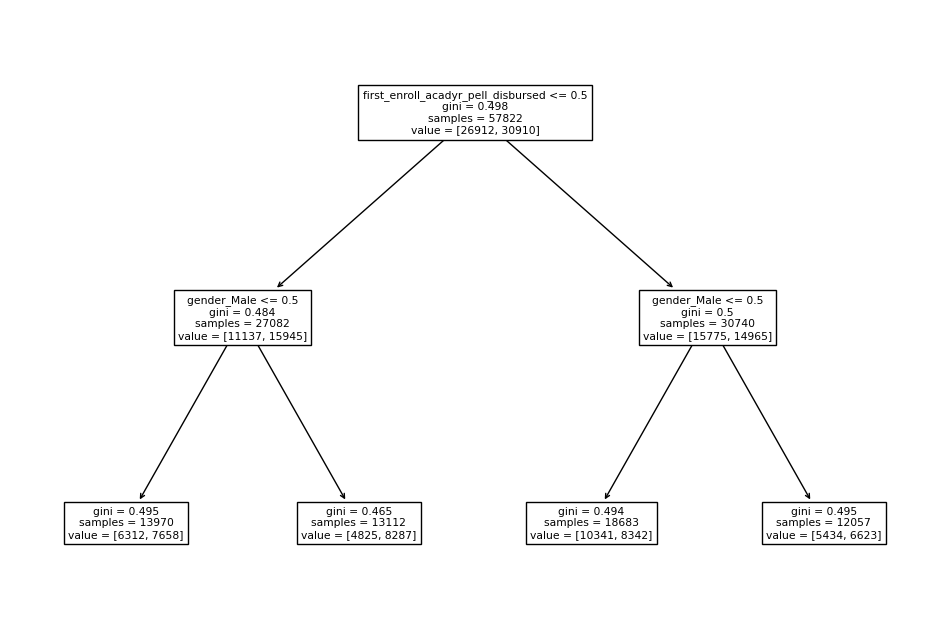

In [11]:
#Run the model
dt = DecisionTreeClassifier(max_depth = 2)
dt_model = dt.fit(X_train,Y_train)

#Plot the decision tree graph
plt.figure(figsize=(12,8))
plot_tree(dt_model, feature_names = list(X_train.columns))

### 2.4 Compare Multiple Models

In this section, we use a loop to run a few models, calculate their metrics at different threshold, and save all results to one DataFrame. This way, it is easier for us to compare results from multiple models at the same time. In addition to the logistic regression and decision tree models, we add two baseline models and the random forest model. We use the **baseline model** to check whether it is necessary to use ML models for prediction. For example, *in a baseline model, we can randomly guess each student's outcome or guess all the students to have positive outcomes*. *If the baseline model is more accurate than our ML models in predicting outcomes, we may need to adjust the ML models or not use them at all.*

> Note that the decision tree model parameters have been adjusted. Now the maximum depth is 7 and the minimum required samples for split a node is 10.

In [12]:
#Define the list of models we will train
models = { 'Baseline_random': np.random.uniform(0,1,len(Y_test)),
           'Baseline_allones': np.ones(len(Y_test)),
           'RandomForest': RandomForestClassifier(n_estimators = 500, max_depth = 3,n_jobs = 2),
           'LogisticRegression': sm.Logit(Y_train,sm.add_constant(X_train)),
           'DecisionTree': DecisionTreeClassifier(max_depth = 7, min_samples_split = 10)
         }

#Define a list of model names for looping
model_list = ['Baseline_random','Baseline_allones','RandomForest','LogisticRegression','DecisionTree']

In [13]:
#Define an empty DataFrame for storing results
df_results = pd.DataFrame()

#Loop through all the models
for m in model_list:

    #Fit models
    if (m == 'Baseline_random' or m =='Baseline_allones'):
        np.random.seed(20)
        y_scores = models[m]
    elif (m == 'RandomForest' or m == 'DecisionTree'):
        clf = models[m].fit(X_train,Y_train.ravel())
        y_scores = clf.predict_proba(X_test)[:,1]
    elif m == 'LogisticRegression':
        clf = models[m].fit()
        y_scores = clf.predict(sm.add_constant(X_test))

    #Calculate metrics at different threshold
    #If you need to add additional metrics and/or threshold, you can add to this list
    a_at_80 = accuracy_at_k(Y_test, y_scores, 0.8) 
    a_at_90 = accuracy_at_k(Y_test, y_scores, 0.9)
    p_at_80 = precision_at_k(Y_test, y_scores, 0.8)
    p_at_90 = precision_at_k(Y_test, y_scores, 0.9)
    r_at_80 = recall_at_k(Y_test, y_scores, 0.8)
    r_at_90 = recall_at_k(Y_test, y_scores, 0.9)

    #Add the results to the df_results DataFrame
    #If you added additional metrics and/or threshold above, you should add them to this list as well
    df_results = df_results._append([{
        'Model':m,
        'accuracy_at_80':a_at_80,
        'precision_at_80':p_at_80,
        'recall_at_80':r_at_80,
        'accuracy_at_90':a_at_90,
        'precision_at_90':p_at_90,
        'recall_at_90':r_at_90,
    }])

#Show results
df_results

Optimization terminated successfully.
         Current function value: 0.676958
         Iterations 4


,Model,accuracy_at_80,precision_at_80,recall_at_80,accuracy_at_90,precision_at_90,recall_at_90
0,Baseline_random,0.526015,0.544301,0.799201,0.536052,0.544955,0.900176
0,Baseline_allones,0.544871,0.544871,1.000000,0.544871,0.544871,1.000000
0,RandomForest,0.565756,0.568535,0.842137,0.555092,0.553191,0.954016
0,LogisticRegression,0.566642,0.569510,0.838413,0.559373,0.557529,0.927062
0,DecisionTree,0.565203,0.568780,0.835297,0.553469,0.552016,0.957673


#### **Checkpoint 2: Use the Evaluation Metrics to Select A Model**

Assume the funding for the policy intervention can only cover 10% of the students. Use the evaluation metrics results in the above table to select a model that allows to you aovid misallocation of resources as much as possible.

## Notebook Reference

This notebook is inspired by previous ADA training courses machine learning notebooks, specifically:

Drew. (2019). Coleridge-Initiative/ada-2019-osu: Published version 1 of OSU ADA training course (v1.0.0). Zenodo. https://doi.org/10.5281/zenodo.2672963

Drew. (2019). Coleridge-Initiative/ada-2019-osu: Published version 1 of OSU ADA training course (v1.0.0). Zenodo. https://doi.org/10.5281/zenodo.2672963

Drew. (2019). Coleridge-Initiative/ada-2019-osu: Published version 1 of OSU ADA training course (v1.0.0). Zenodo. https://doi.org/10.5281/zenodo.2672963

Lou, T. (2022, March 18). Machine Learning Model Development and Feature Creation Using Illinois Unemployment Insurance Data. Zenodo. https://doi.org/10.5281/zenodo.6368905

Lou, T. (2022, March 18). Machine Learning Model Deployment and Evaluation Using Illinois Unemployment Insurance Data. Zenodo. https://doi.org/10.5281/zenodo.6369160